## 

## Workshop Day 1

In [13]:
# Dependencies 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
import os

from util import *


# Part 1: Extract and visualize data 
Extracting data 
Dataset contains:
-  levelground - 3 different speeds, clockwise and counterclockwise loops
-  ramp - Ascent and descent for 6 inclinations
-  stair - Ascent and descent for 4 step heights


Extract data of person walking with exoskeleton. 

In [26]:
df_list = []

# Iterate over all files in the directory
for filename in os.listdir("../data/"):
    if filename.endswith('_ml_dataset_extracted.csv'):
        print(filename)
        # Construct full file path
        file_path = os.path.join("../data/", filename)
        # Read CSV file into DataFrame
        df = pd.read_csv(file_path)
        # Append DataFrame to list
        df_list.append(df)

# Concatenate all DataFrames in the list
df = pd.concat(df_list, ignore_index=True)

# Display the columns of the DataFrame
print("\nColumns in the DataFrame:")
print(df.columns)



Columns in the DataFrame:
Index(['Unnamed: 0', 'time', ' JointPositions_1', ' JointPositions_2',
       ' JointPositions_3', ' JointPositions_4', ' JointVelocities_1',
       ' JointVelocities_2', ' JointVelocities_3', ' JointVelocities_4',
       ' JointTorques_1', ' JointTorques_2', ' JointTorques_3',
       ' JointTorques_4', ' DesiredJointTorques_1', ' DesiredJointTorques_2',
       ' DesiredJointTorques_3', ' DesiredJointTorques_4',
       ' JointTorquesViaGauges_1', ' JointTorquesViaGauges_2',
       ' JointTorquesViaGauges_3', ' JointTorquesViaGauges_4',
       ' InteractionForces_1', ' InteractionForces_2', ' InteractionForces_3',
       ' InteractionForces_4', ' InteractionForces_5',
       ' SmoothedInteractionForces_1', ' SmoothedInteractionForces_2',
       ' SmoothedInteractionForces_3', ' SmoothedInteractionForces_4',
       ' SmoothedInteractionForces_5', ' enableRenderingFlag',
       ' DesiredInteractionForces_1', ' DesiredInteractionForces_2',
       ' DesiredInterac

In this dataset people perform stairs, ramps, overground walking. 

In two conditions: exoskeleton in transparent mode, exoskeleton controlled using a state machine

In [27]:
print(np.unique(df['condition']))

['SM_RAMPS_DOWN' 'SM_RAMPS_UP' 'SM_STAIRS_DOWN' 'SM_STAIRS_UP'
 'SM_UNDEFINED' 'SM_WALKING' 'transparent_RAMPS_DOWN'
 'transparent_RAMPS_UP' 'transparent_STAIRS_DOWN' 'transparent_STAIRS_UP'
 'transparent_UNDEFINED' 'transparent_WALKING']


For the purpose of the experiment we will only observe Walking (both in transparent mode and in State Machine mode). 

We create two different df, one for SM one for transparent

In [28]:
df_Transparent = df[df['condition'] == 'transparent_WALKING']
df_StateMachine = df[df['condition'] == 'SM_WALKING']

Display joint angles:
-  JointPosition1 = Left hip, 
-  JointPosition2= Left Knee, 
-  JointPosition3= Right Hip, 
-  JointPosition4 = Right Knee

Angles are in radians, for clarity they are plotted in deg

Together with Joint position we display also stance interpolation factor represented as:
$equation$
This allows to understand what stance the robot is in that specific moment
In particular: 1== left stance, 0 == right stance

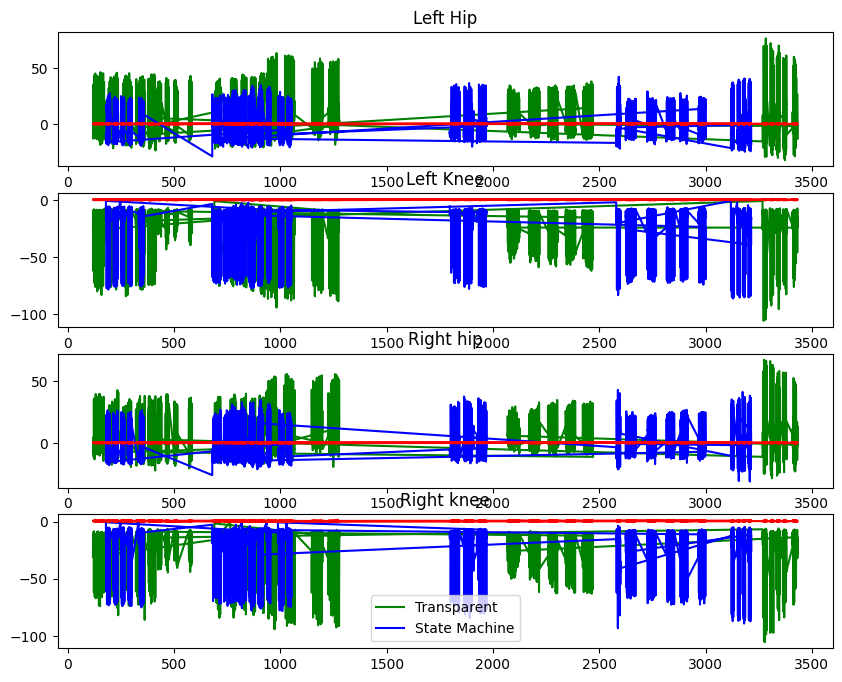

In [38]:
fig, axs = plt.subplots(4, figsize=(10, 8))

#transparent
axs[0].plot(df_Transparent['time'], df_Transparent[' JointPositions_1']*180/np.pi, 'g-')
axs[0].plot(df_Transparent['time'], df_Transparent[' StanceInterpolationFactor'], 'r-')
axs[0].set_title('Left Hip')
axs[1].plot(df_Transparent['time'], df_Transparent[' JointPositions_2']*180/np.pi, 'g-')
axs[1].plot(df_Transparent['time'], df_Transparent[' StanceInterpolationFactor'], 'r-')
axs[1].set_title('Left Knee')
axs[2].plot(df_Transparent['time'], df_Transparent[' JointPositions_3']*180/np.pi, 'g-')
axs[2].plot(df_Transparent['time'], df_Transparent[' StanceInterpolationFactor'], 'r-')
axs[2].set_title('Right hip')
axs[3].plot(df_Transparent['time'], df_Transparent[' JointPositions_4']*180/np.pi, 'g-', label= "Transparent")
axs[3].plot(df_Transparent['time'], df_Transparent[' StanceInterpolationFactor'], 'r-')
axs[3].set_title('Right knee')

#state machine
axs[0].plot(df_StateMachine['time'], df_StateMachine[' JointPositions_1']*180/np.pi, 'b-')
axs[0].plot(df_StateMachine['time'], df_StateMachine[' StanceInterpolationFactor'], 'r-')
axs[1].plot(df_StateMachine['time'], df_StateMachine[' JointPositions_2']*180/np.pi, 'b-')
axs[1].plot(df_StateMachine['time'], df_StateMachine[' StanceInterpolationFactor'], 'r-')
axs[2].plot(df_StateMachine['time'], df_StateMachine[' JointPositions_3']*180/np.pi, 'b-')
axs[2].plot(df_StateMachine['time'], df_StateMachine[' StanceInterpolationFactor'], 'r-')
axs[3].plot(df_StateMachine['time'], df_StateMachine[' JointPositions_4']*180/np.pi, 'b-', label= "State Machine")
axs[3].plot(df_StateMachine['time'], df_StateMachine[' StanceInterpolationFactor'], 'r-')

plt.legend()
plt.show()

**Exercice 1** Segment gait in strides using the stance interpolation factor and display it

In [39]:
def segment_stride(stance_interpolate_factor, joint, segment_length=100):
    """
    Segments gait using stance interpolation factor.

    """
    segments_alpha = []
    segments_theta = []
    start_index = 0
    completed_gait = False

    for i in range(1, len(stance_interpolate_factor)):
        if stance_interpolate_factor[i] == 1:
            completed_gait = True
        elif completed_gait and stance_interpolate_factor[i] == 0:
            segments_alpha.append(stance_interpolate_factor[start_index:i])
            segments_theta.append(joint[start_index:i])
            start_index = i
            completed_gait = False

    interpolated_segments_alpha = []
    interpolated_segments_theta = []
    for segment_al, segment_th in zip(segments_alpha, segments_theta):
        if len(segment_al)< 1500:
            x = np.linspace(0, 1, len(segment_al))
            f = interp1d(x, segment_al, kind='linear')
            x_new = np.linspace(0, 1, segment_length)
            interpolated_segments_alpha.append(f(x_new))
            
            x = np.linspace(0, 1, len(segment_th))
            f = interp1d(x, segment_th, kind='linear')
            interpolated_segments_theta.append(f(x_new))

    return np.array(interpolated_segments_alpha), np.array(interpolated_segments_theta)


In [40]:
# transparent
segmented_joints_transparent ={0:[], 1: [], 2:[], 3:[]}
segmented_alpha_transparent, segmented_joints_transparent[0] = segment_stride(df_Transparent[' StanceInterpolationFactor'].to_numpy(), 
                                                                              df_Transparent[' JointPositions_1'].to_numpy())
_, segmented_joints_transparent[1] = segment_stride(df_Transparent[' StanceInterpolationFactor'].to_numpy(), 
                                                    df_Transparent[' JointPositions_2'].to_numpy())
_, segmented_joints_transparent[2] = segment_stride(df_Transparent[' StanceInterpolationFactor'].to_numpy(), 
                                                    df_Transparent[' JointPositions_3'].to_numpy())
_, segmented_joints_transparent[3] = segment_stride(df_Transparent[' StanceInterpolationFactor'].to_numpy(), 
                                                    df_Transparent[' JointPositions_4'].to_numpy())

print("Segmented alpha transparent shape ",segmented_alpha_transparent.shape)
print("Segmented joint 1 transparent shape ", segmented_joints_transparent[0].shape)
print("Segmented joint 2 transparent shape ",segmented_joints_transparent[1].shape)
print("Segmented joint 3 transparent shape ",segmented_joints_transparent[2].shape)
print("Segmented joint 4 transparent shape ",segmented_joints_transparent[3].shape)

# State Machine 
segmented_joints_SM= {0:[], 1: [], 2:[], 3:[]}
segmented_alpha_SM, segmented_joints_SM[0] = segment_stride(df_StateMachine[' StanceInterpolationFactor'].to_numpy(), 
                                                            df_StateMachine[' JointPositions_1'].to_numpy())
_, segmented_joints_SM[1] = segment_stride(df_StateMachine[' StanceInterpolationFactor'].to_numpy(), 
                                            df_StateMachine[' JointPositions_2'].to_numpy())
_, segmented_joints_SM[2] = segment_stride(df_StateMachine[' StanceInterpolationFactor'].to_numpy(), 
                                            df_StateMachine[' JointPositions_3'].to_numpy())
_, segmented_joints_SM[3] = segment_stride(df_StateMachine[' StanceInterpolationFactor'].to_numpy(), 
                                            df_StateMachine[' JointPositions_4'].to_numpy())

print("Segmented alpha state machine shape ",segmented_alpha_SM.shape)
print("Segmented joint 1 state machine shape ", segmented_joints_SM[0].shape)
print("Segmented joint 2 state machine shape ",segmented_joints_SM[1].shape)
print("Segmented joint 3 state machine shape ",segmented_joints_SM[2].shape)
print("Segmented joint 4 state machine shape ",segmented_joints_SM[3].shape)


Segmented alpha transparent shape  (221, 100)
Segmented joint 1 transparent shape  (221, 100)
Segmented joint 2 transparent shape  (221, 100)
Segmented joint 3 transparent shape  (221, 100)
Segmented joint 4 transparent shape  (221, 100)
Segmented alpha state machine shape  (229, 100)
Segmented joint 1 state machine shape  (229, 100)
Segmented joint 2 state machine shape  (229, 100)
Segmented joint 3 state machine shape  (229, 100)
Segmented joint 4 state machine shape  (229, 100)


Plot steps (with mean and variance)

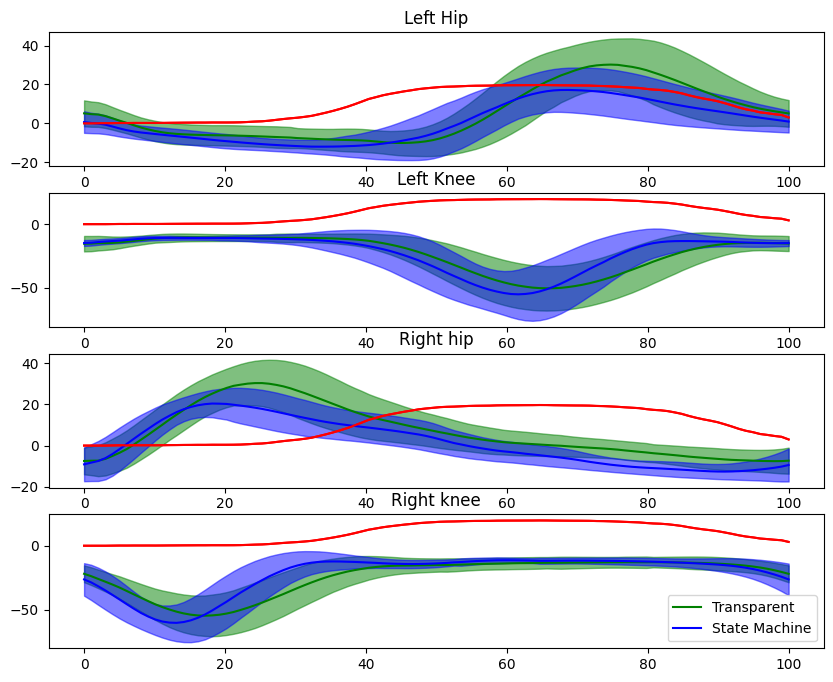

In [41]:
fig, axs = plt.subplots(4, figsize=(10, 8))
axs[0].set_title('Left Hip')
axs[1].set_title('Left Knee')
axs[2].set_title('Right hip')
axs[3].set_title('Right knee')

#transparent
for i in range(4):
    axs[i].plot(np.linspace(0, 100, 100), np.mean(segmented_joints_transparent[i], 0)*180/np.pi, 'g-', label= "Transparent")
    axs[i].fill_between(np.linspace(0, 100, 100), 
                        (np.mean(segmented_joints_transparent[i], 0)- np.std(segmented_joints_transparent[i], 0))*180/np.pi,
                        (np.mean(segmented_joints_transparent[i], 0) + np.std(segmented_joints_transparent[i], 0))*180/np.pi, color='g', alpha=0.5)
    axs[i].plot(np.linspace(0, 100, 100), np.mean(segmented_alpha_transparent, 0)*20, 'r-')

    # STate machine
    axs[i].plot(np.linspace(0, 100, 100), np.mean(segmented_joints_SM[i], 0)*180/np.pi, 'b-', label= "State Machine")
    axs[i].fill_between(np.linspace(0, 100, 100), 
                        (np.mean(segmented_joints_SM[i], 0)- np.std(segmented_joints_SM[i], 0))*180/np.pi,
                        (np.mean(segmented_joints_SM[i], 0) + np.std(segmented_joints_SM[i], 0))*180/np.pi, color='b', alpha=0.5)
    axs[i].plot(np.linspace(0, 100, 100), np.mean(segmented_alpha_transparent, 0)*20, 'r-')

plt.legend()
plt.show()

# TODO check jump 0, 100


Save the mean vector (over the gait phase) for Day 2 workshop

In [32]:

for i in range(4):
    np.save("../data/joint_"+str(i)+"_transparent_over_gaitphase", np.mean(segmented_joints_transparent[i], 0))
    np.save("../data/joint_"+str(i)+"_SM_over_gaitphase", np.mean(segmented_joints_SM[i], 0))


# Part 2: Segment stride in motion primitive and extract equilibrium angles 


**Exercice 2** Find the equilibrium angles, ideally they should be the angles the joint reaches and then changes the trajectory. 

Hint: 
- joint accelleration
- ideally four equilibrium angles since we design a state machine with 4 gait phases
- here we select 6 using local maxima and local minima
- feel free to manually remove some of them to have 4 and to better fit (remember the transition should happen at the same time across the four angles so the more they overlap the better it is)


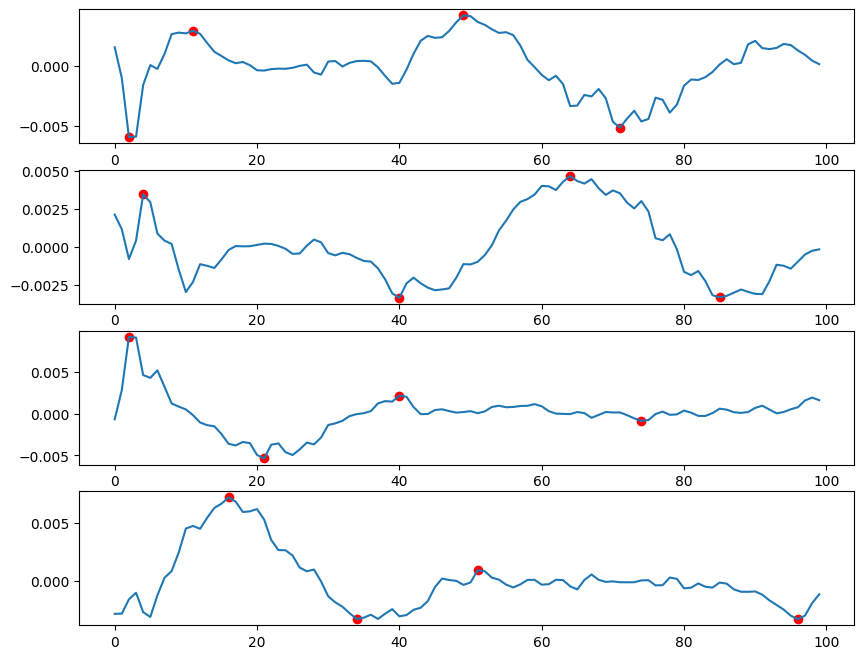

In [42]:
N_ANGLES= 4

fig, axs = plt.subplots(4, figsize=(10, 8))
local_extremes ={0:[], 1:[], 2:[], 3:[]}
for i in range(4):
    joint = np.mean(segmented_joints_transparent[i], 0)

    # function local extrema
    local_max = find_local_maxima(np.gradient(np.gradient(joint)), N_ANGLES//2)
    local_min = find_local_maxima(-np.gradient(np.gradient(joint)), N_ANGLES//2)
    local_extremes[i]= np.concatenate((local_max, local_min) , 0)
    axs[i].plot(np.gradient(np.gradient(joint)))
    for ex in local_extremes[i]:            
        axs[i].scatter(ex, np.gradient(np.gradient(joint))[ex], color= 'r')

plt.show()


Potential equilibrium angles joint  0
4.49253253728186
-4.654514483307879
-8.692778321788186
29.274789672694396
Potential equilibrium angles joint  1
-14.721384905205271
-13.079098763933509
-50.20324078850044
-20.45190610127932
Potential equilibrium angles joint  2
-7.3043796443956674
29.016759238700697
14.139575426725376
-1.6806787628132998
Potential equilibrium angles joint  3
-54.32792703117667
-24.619908537250197
-15.003979199199819
-17.92976472121217


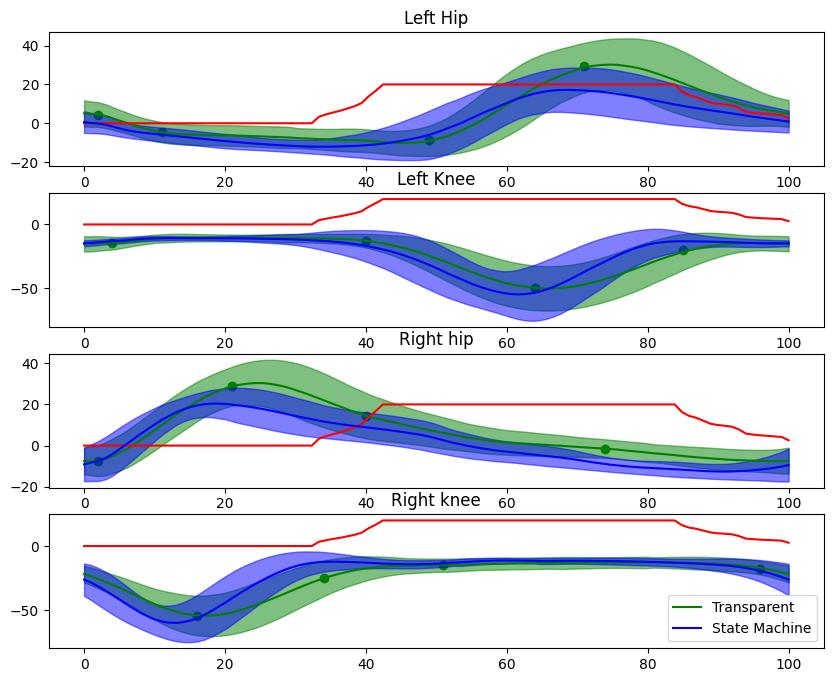

In [43]:
fig, axs = plt.subplots(4, figsize=(10, 8))
axs[0].set_title('Left Hip')
axs[1].set_title('Left Knee')
axs[2].set_title('Right hip')
axs[3].set_title('Right knee')

for i in range(4):
    #transparent
    axs[i].plot(np.linspace(0, 100, 100), np.mean(segmented_joints_transparent[i], 0)*180/np.pi, 'g-', label= "Transparent")
    axs[i].fill_between(np.linspace(0, 100, 100), 
                        (np.mean(segmented_joints_transparent[i], 0)- np.std(segmented_joints_transparent[i], 0))*180/np.pi,
                        (np.mean(segmented_joints_transparent[i], 0) + np.std(segmented_joints_transparent[i], 0))*180/np.pi, color='g', alpha=0.5)
    axs[i].plot(np.linspace(0, 100, 100), np.median(segmented_alpha_transparent, 0)*20, 'r-')
    
    # plot local extreme
    print("Potential equilibrium angles joint ", i)
    for ext in np.sort(local_extremes[i]):
        axs[i].scatter(ext, (np.mean(segmented_joints_transparent[i], 0)[ext])*180/np.pi, color='g')
        print((np.mean(segmented_joints_transparent[i], 0)[ext])*180/np.pi)

    # STate machine
    axs[i].plot(np.linspace(0, 100, 100), np.mean(segmented_joints_SM[i], 0)*180/np.pi, 'b-', label= "State Machine")
    axs[i].fill_between(np.linspace(0, 100, 100), 
                        (np.mean(segmented_joints_SM[i], 0)- np.std(segmented_joints_SM[i], 0))*180/np.pi,
                        (np.mean(segmented_joints_SM[i], 0) + np.std(segmented_joints_SM[i], 0))*180/np.pi, color='b', alpha=0.5)

plt.legend()
plt.show()

Using stance interpolation factor and angle trend break the the stride in such a way that:
- Having 4 gait states for each leg: early stance, late stance, early swing, late swing
- transition must be always: early stance --> late stance --> early swing --> late swing --> early stance
- The gait phase must be symmetrical. Namelly, early stance results in early swing for the other, late stance for one results in late swing for the other. 
- Monotonic movement inside a same gait phase and the breaking should be close to one of the equilibrium points identified.  

In [35]:
GAIT_PHASES= ["EarlyStance", "LateStance", "EarlySwing", "LateSwing"]

**Exercice 2** find the best transitions.
Some hints: 
- values should be (more or less) symmetrical so concentrate on one leg then check other leg in case adjust
- swing --> stance suggested by the value of stance interpolation factor (alpha == 0 mean left stance, alpha ==1 means right stance)
- internal transition (early to late) watch angles of the swing leg
- remember the values are periodic so values at the end and at the beginning are close each other


In [44]:
print("Indices Potential Equilibrium angle Left Hip ", np.sort(local_extremes[0]))
print("Indices Potential Equilibrium angle Left Knee ", np.sort(local_extremes[1]))
print("Indices Potential Equilibrium angle Right Hip ", np.sort(local_extremes[2]))
print("Indices Potential Equilibrium angle Right Knee ", np.sort(local_extremes[3]))

alpha =np.median(segmented_alpha_transparent, 0)
right_hip = np.mean(segmented_joints_transparent[2], 0)*180/np.pi
Est_to_Lst = np.where(right_hip>25)[0][0]
Lst_to_Esw = np.where(alpha>0.3)[0][0]
left_hip = np.mean(segmented_joints_transparent[0], 0)*180/np.pi
Esw_to_Lsw = np.where(left_hip>25)[0][0]
Lsw_to_Est = np.where(alpha>0.7)[0][-1]

print(Est_to_Lst, Lst_to_Esw, Esw_to_Lsw, Lsw_to_Est)

Indices Potential Equilibrium angle Left Hip  [ 2 11 49 71]
Indices Potential Equilibrium angle Left Knee  [ 4 40 64 85]
Indices Potential Equilibrium angle Right Hip  [ 2 21 40 74]
Indices Potential Equilibrium angle Right Knee  [16 34 51 96]
18 36 68 85


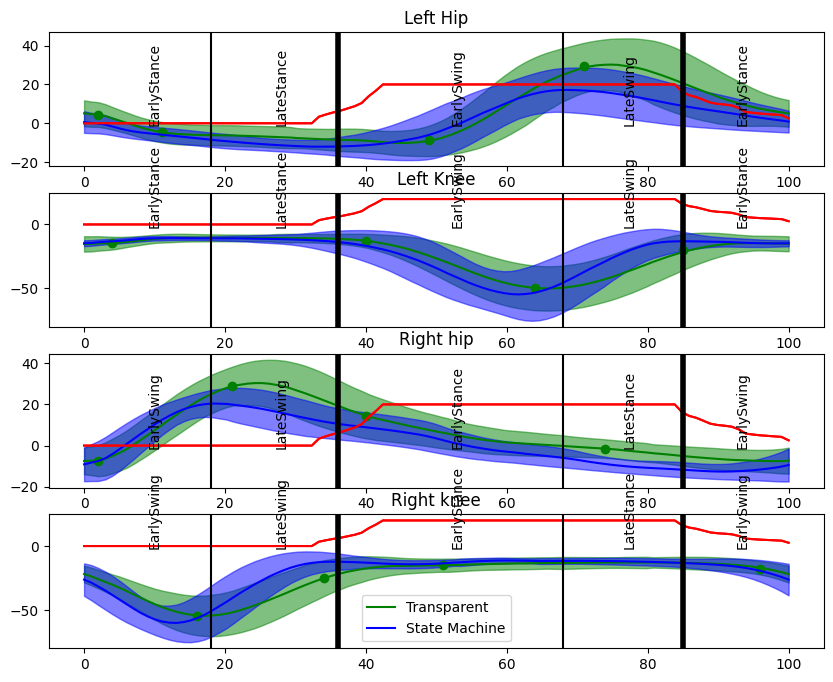

In [45]:
fig, axs = plt.subplots(4, figsize=(10, 8))
axs[0].set_title('Left Hip')
axs[1].set_title('Left Knee')
axs[2].set_title('Right hip')
axs[3].set_title('Right knee')

for i in range(4):
    #transparent
    axs[i].plot(np.linspace(0, 100, 100), np.mean(segmented_joints_transparent[i], 0)*180/np.pi, 'g-', label= "Transparent")
    axs[i].fill_between(np.linspace(0, 100, 100), 
                        (np.mean(segmented_joints_transparent[i], 0)- np.std(segmented_joints_transparent[i], 0))*180/np.pi,
                        (np.mean(segmented_joints_transparent[i], 0) + np.std(segmented_joints_transparent[i], 0))*180/np.pi, color='g', alpha=0.5)
    axs[i].plot(np.linspace(0, 100, 100), np.median(segmented_alpha_transparent, 0)*20, 'r-')

    # STate machine
    axs[i].plot(np.linspace(0, 100, 100), np.mean(segmented_joints_SM[i], 0)*180/np.pi, 'b-', label= "State Machine")
    axs[i].fill_between(np.linspace(0, 100, 100), 
                        (np.mean(segmented_joints_SM[i], 0)- np.std(segmented_joints_SM[i], 0))*180/np.pi,
                        (np.mean(segmented_joints_SM[i], 0) + np.std(segmented_joints_SM[i], 0))*180/np.pi, color='b', alpha=0.5)
    axs[i].plot(np.linspace(0, 100, 100), np.median(segmented_alpha_transparent, 0)*20, 'r-')
    
    # plot local extreme
    for ext in local_extremes[i]:
        axs[i].scatter(ext, np.mean(segmented_joints_transparent[i], 0)[ext]*180/np.pi, color='g')

    
    axs[i].axvline(x = Est_to_Lst, color = 'black', )
    axs[i].axvline(x = Lst_to_Esw, color = 'black', linewidth=4)
    axs[i].axvline(x = Esw_to_Lsw, color = 'black')
    axs[i].axvline(x = Lsw_to_Est, color = 'black', linewidth=4)
    
    if i<2:
        axs[i].text(Est_to_Lst/2, 0, GAIT_PHASES[0], rotation=90, fontsize = 10)
        axs[i].text((Est_to_Lst + Lst_to_Esw)/2, 0, GAIT_PHASES[1], rotation=90, fontsize = 10)
        axs[i].text((Lst_to_Esw + Esw_to_Lsw)/2, 0, GAIT_PHASES[2], rotation=90, fontsize = 10)
        axs[i].text((Esw_to_Lsw + Lsw_to_Est)/2, 0, GAIT_PHASES[3], rotation=90, fontsize = 10)
        axs[i].text((100 + Lsw_to_Est)/2, 0, GAIT_PHASES[0], rotation=90, fontsize = 10)
    else:
        axs[i].text(Est_to_Lst/2, 0, GAIT_PHASES[2], rotation=90, fontsize = 10)
        axs[i].text((Est_to_Lst + Lst_to_Esw)/2, 0, GAIT_PHASES[3], rotation=90, fontsize = 10)
        axs[i].text((Lst_to_Esw + Esw_to_Lsw)/2, 0, GAIT_PHASES[0], rotation=90, fontsize = 10)
        axs[i].text((Esw_to_Lsw + Lsw_to_Est)/2, 0, GAIT_PHASES[1], rotation=90, fontsize = 10)
        axs[i].text((100 + Lsw_to_Est)/2, 0, GAIT_PHASES[2], rotation=90, fontsize = 10)
    

plt.legend()
plt.show()

Resulting Angle to be be tested on robot

In [17]:
print("Transition from Early stance to late stance (wrt left leg)", (np.mean(segmented_joints_transparent[2], 0)[Est_to_Lst])*180/np.pi )
print("Transition from Early Swing to late Swing (wrt left leg)", np.mean(segmented_joints_transparent[0], 0)[Esw_to_Lsw]*180/np.pi )

Transition from Early stance to late stance (wrt left leg) 25.46285874741857
Transition from Early Swing to late Swing (wrt left leg) 25.499609363500692


# Part 3: Test on robot